#Spark-based Provenance Kernel Machine Learning demo
In this notebook, we will run below steps to make predictions on either sparse matrices we generated from type counting(pair-matching demo or motiffinding demo) or upload the csv files we provided

First, we import all the required packages

In [0]:
import os
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
import time
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, OneVsRest, NaiveBayes, MultilayerPerceptronClassifier,RandomForestClassifier,DecisionTreeClassifier,LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


Out[5]: ['CM-Buildings',
 'CM-BuildingsNP.csv',
 'CM-BuildingsP.csv',
 'CM-RouteSets',
 'CM-RouteSetsNP.csv',
 'CM-RouteSetsP.csv',
 'CM-Routes',
 'CM-RoutesNP.csv',
 'CM-RoutesP.csv',
 'PG-D',
 'PG-DNP.csv',
 'PG-DP.csv',
 'PG-T',
 'PG-TNP.csv',
 'PG-TP.csv',
 'final_res.p',
 'ovr_res.p']

In [0]:
os.listdir("") #enter the main directory of your path here

Belows are the paths we used during our developments. You can upload your choice of matrices data via the "upload data" button. Right click the dropdown bar of "Files" and follow the intructions. Upon completion of upload, use the cell above to find the data in your directory. Your path should look similar to our testpath defined in below cell.

In [0]:
testpath = "/dbfs/FileStore/shared_uploads/jian.1.huang@kcl.ac.uk/provSpark-datasets/CM-RoutesNP.orc" # your path should look like this
datasetFull = ["CM-BuildingsNP.orc","CM-BuildingsP.orc","CM-RoutesNP.orc","CM-RoutesP.orc","CM-RouteSetsNP.orc","CM-RouteSetsP.orc","PG-TNP.orc","PG-TP.orc","PG-DNP.orc","PG-DP.orc"] #your files names should look like the files in this list

#change the list below to your files names unless you generated the matrices with our methods over the same datasets
datasets = ["CM-BuildingsNP.orc","CM-RoutesNP.orc","CM-RouteSetsNP.orc","PG-TNP.orc","PG-DNP.orc"] 
datasetsP = ["CM-BuildingsP.orc","CM-RoutesP.orc","CM-RouteSetsP.orc","PG-TP.orc","PG-DP.orc"]
#This should be the list of your filenames without the file formats
dataset_proper_names = ["CM-BuildingsNP","CM-BuildingsP","CM-RoutesNP","CM-RoutesP","CM-RouteSetsNP","CM-RouteSetsP","PG-TNP","PG-TP","PG-DNP","PG-DP"]
#this should be where your datasets is uploaded
mainpath = "/dbfs/FileStore/shared_uploads/jian.1.huang@kcl.ac.uk/provSpark-datasets"

Uncomment and run cell belows if you choose to upload the csv data we provided

In [0]:
# def reproduce(path,datasetnames):
#     for ds in datasetnames:
#         df = spark.read(path+"/"+ds+".csv")
#         df.write.format("orc").save(path+"/"+ds+".orc")
# reproduce (mainpath, dataset_proper_names)

Let's take a look at CM-BuildingsNP dataset generated by pair-matching algorithm

In [0]:
spark.read.orc(mainpath+"/"+datasets[0]).display()


"[('der', 'gen'), ('der', 'usd'), ('ent', 'ent')]","[['der', 'der', 'ent']]","[['der', 'ent'], ['der', 'ent'], ['der', 'ent'], ['der', 'ent'], ['der', 'ent'], ['gen', 'act']]","[['der', 'ent'], ['der', 'ent'], ['der', 'ent'], ['der', 'ent'], ['gen', 'act']]","[['der', 'ent'], ['der', 'ent'], ['der', 'ent'], ['gen', 'act']]","[['der', 'ent'], ['der', 'ent'], ['gen', 'act']]","[['der', 'ent'], ['gen', 'act']]","[['der', 'ent']]","[['gen', 'usd', 'ent']]","[['usd', 'der', 'ent']]","[['usd', 'ent'], ['usd', 'ent'], ['usd', 'ent'], ['usd', 'ent']]","[['usd', 'ent'], ['usd', 'ent'], ['usd', 'ent']]","[['usd', 'ent'], ['usd', 'ent']]","[['usd', 'ent']]",act,ent,label
0,0,0,0,0,0,2,1,2,0,0,0,0,2,2,4,Trusted
2,6,0,0,0,5,6,1,3,6,0,0,3,6,9,13,Trusted
2,4,0,0,0,4,5,1,3,4,0,0,2,5,7,11,Trusted
0,0,0,0,0,0,2,1,2,0,0,0,0,2,2,4,Trusted
2,4,0,0,0,4,5,1,3,4,0,0,2,5,7,11,Trusted
2,2,0,0,0,3,4,1,3,2,0,0,1,4,5,9,Trusted
2,6,0,0,0,5,6,1,3,6,0,0,3,6,9,13,Trusted
2,6,0,0,0,5,6,1,3,6,0,0,3,6,9,13,Trusted
2,8,0,0,1,10,8,1,3,6,0,3,1,8,12,21,Trusted
2,2,0,0,0,3,4,1,3,2,0,0,1,4,5,9,Trusted


To begin the machine learning training, we defined a few functions to help format our data

In [0]:
#function used to find class size
def gen_labelDict(path):
  data = spark.read.orc(path)
  labelList = data.select('label').distinct().rdd.map(lambda r: r[0]).collect()
  labelDict = {}
  for i in range(len(labelList)):
    labelDict[labelList[i]] = i
  return labelDict
#function that formats and combines our features to a single column of feature vectors
def formatData(path):
  data = spark.read.orc(path)
  labelDict = gen_labelDict(path)
  data = data.toPandas().replace({"label": labelDict}) 
  spark.conf.set("spark.sql.execution.arrow.enabled", "true")
  data = spark.createDataFrame(data)
  assembler = VectorAssembler(
    inputCols=[c for c in data.columns if c != 'label'],
    outputCol="features")
  df = assembler.transform(data).select("features", "label")
  return df

In [0]:
# 10 folds Cross-validation evaluation function 
def evaluate(classifier,train,test,selectedEvaluator):
  
  paramGrid = ParamGridBuilder().build()
  crossval = CrossValidator(estimator=classifier,\
  evaluator=selectedEvaluator, \
  estimatorParamMaps=paramGrid,\
  numFolds=10)
  cvModel = crossval.fit(train)
  cvModel_metrics = cvModel.avgMetrics
  transformed_data = cvModel.transform(test)
  test_metrics = selectedEvaluator.evaluate(transformed_data)
  return (cvModel_metrics, test_metrics)

Here we defined the function that trains each classifier

In [0]:
def trainClassifiers(mainpath,dataset):
  testpath = mainpath+"/"+dataset
  labelDict = gen_labelDict(testpath)
  df = formatData(testpath)
  labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(df)
  # Scale features.
  featureIndexer =\
      VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(df)

  # generate the train/test split.
  (train, test) = df.randomSplit([0.7, 0.3])
  
  lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)
  classifierDict = {
    "LR":lr,
    "SVM": LinearSVC(maxIter=10, regParam=0.1),
    "OvR": OneVsRest(classifier=lr),
    "NB" : NaiveBayes(smoothing=1.0, modelType="multinomial"),
    "RF" : RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10),
    "DT" : DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")
  }
  if len(labelDict)>2:
    classifierDict.pop("SVM")
  accDict = {}
  
  for classifier in classifierDict.keys():
    pipeline = Pipeline(stages=[labelIndexer, featureIndexer, classifierDict[classifier]])
    #if the iterated classifier is Decision tree or Random forest, we assigned their evaluation columns properly (this is where we debugged experiment 2 in the report)
    if (classifier == "DT") or (classifier=="RF"):
      evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction",metricName="accuracy")
      accDict [classifier]=evaluate(pipeline,train,test,evaluator)
    else:
      evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
      accDict [classifier]=evaluate(pipeline,train,test,evaluator)

  return accDict
testResult = trainClassifiers(mainpath,datasets[0])
testResult

/databricks/spark/python/pyspark/ml/util.py:762: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)
Out[12]: {'LR': ([0.9462668863693203], 0.9534282018111255),
 'SVM': ([0.8668254162233606], 0.869987063389392),
 'OvR': ([0.9462668863693203], 0.9534282018111255),
 'NB': ([0.7607485522068912], 0.7781371280724451),
 'RF': ([0.956342357342635], 0.96248382923674),
 'DT': ([0.9565690913315033], 0.964424320827943)}

Here we assign a few convient functions for us to collect cross-validation training loss and test prediction from a nested dictionary anytime we want

In [0]:
def queryCrossvalAvg(result):
  queriedResult = {}
  for res in result.keys():
    queriedResult[res] = result[res][0][0]
  return {"Accuracy":queriedResult}
def queryCrossvalTest(result):
  queriedResult = {}
  for res in result.keys():
    queriedResult[res] = result[res][1]
  return {"Accuracy":queriedResult}

We will take a quick loock at the Non-primitive CM-Buildings results first to make sure everything is going well so far. We plot out the collective values of both training loss and predictions

Out[14]:

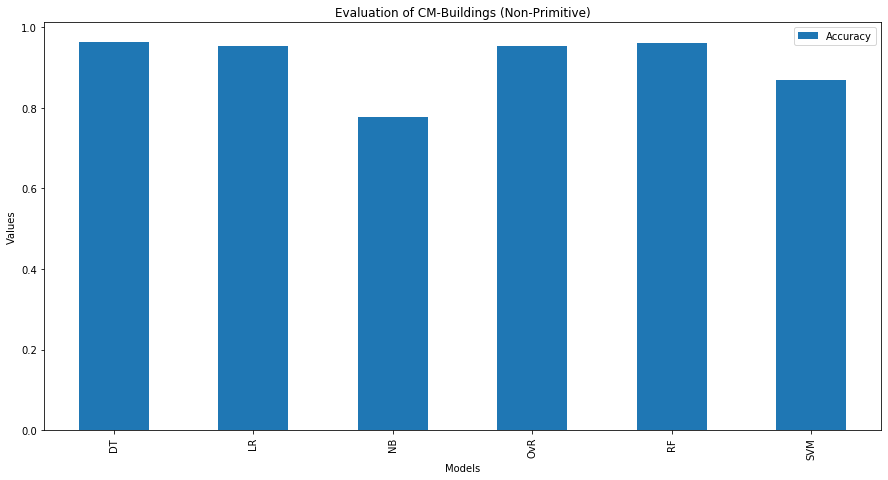

Text(0, 0.5, 'Values')

In [0]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
dfRes = pd.DataFrame(queryCrossvalTest(testResult))

dfRes.plot(kind="bar", title="test",figsize=(10*1.5, 5*1.5))

plt.title("Evaluation of CM-Buildings (Non-Primitive)")
plt.xlabel("Models")
plt.ylabel("Values")

In [0]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
dfRes = pd.DataFrame(queryCrossvalAvg(testResult))

dfRes.plot(kind="bar", title="test",figsize=(10*1.5, 5*1.5))

plt.title("Evaluation of CM-Buildings (Non-Primitive)")
plt.xlabel("Models")
plt.ylabel("Values")

In [0]:
#functions for plotting certain dataframes
def plotRes(res,dataset_name,shouldTranspose):
  dfRes = pd.DataFrame(res)
  if shouldTranspose:
    dfRes = dfRes.transpose()
  dfRes.plot(kind="bar", title="test")
  plt.title("Evaluation of "+ dataset_name)
  plt.xlabel("Models")
  plt.ylabel("Values")
#plotRes(queryCrossvalTest(testResult),"CM-B_NP",False)

we the generate the overall results (all classifiers over all datasets)

In [0]:
def produceOverallResults(mainpath,datasets,datasetsP):
  NP_dict = {}
  P_dict = {}
  for dataset in datasets:
    NP_dict[dataset]=queryCrossvalTest(trainClassifiers(mainpath,dataset))
  for datasetP in datasetsP:
    P_dict[datasetP]=queryCrossvalTest(trainClassifiers(mainpath,datasetP))
  return [NP_dict,P_dict]
ovr_res = produceOverallResults(mainpath,datasets,datasetsP)

We then store the results for later uses. *by using it you will overwrite the file uploaded, if you choose to use our provided data. or you can avoid this by change the pickle file name*

In [0]:
# with open(mainpath+'/'+'final_res.p', 'wb') as fp:
#     pickle.dump(ovr_res, fp, protocol=pickle.HIGHEST_PROTOCOL)

here we begins our analysis process (experiment 2 and assessment 2)

In [0]:
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle
testpath = "/dbfs/FileStore/shared_uploads/jian.1.huang@kcl.ac.uk/provSpark-datasets/CM-RoutesNP.orc"
datasets = ["CM-BuildingsNP.orc","CM-RoutesNP.orc","CM-RouteSetsNP.orc","PG-TNP.orc","PG-DNP.orc"]
datasetsP = ["CM-BuildingsP.orc","CM-RoutesP.orc","CM-RouteSetsP.orc","PG-TP.orc","PG-DP.orc"]
datasetFull = ["CM-BuildingsNP.orc","CM-BuildingsP.orc","CM-RoutesNP.orc","CM-RoutesP.orc","CM-RouteSetsNP.orc","CM-RouteSetsP.orc","PG-TNP.orc","PG-TP.orc","PG-DNP.orc","PG-DP.orc"]
mainpath = "/dbfs/FileStore/shared_uploads/jian.1.huang@kcl.ac.uk/provSpark-datasets"

load the results data

In [0]:
with open(mainpath+'/'+'final_res.p', 'rb') as fp:
    dictsaved = pickle.load(fp)

have a quick check at our results

In [0]:
dictsaved[0]

Out[3]: {'CM-RoutesNP.orc': {'Accuracy': {'LR': 0.938058748403576,
 'SVM': 0.7931034482758621,
 'OvR': 0.938058748403576,
 'NB': 0.9540229885057471,
 'RF': 0.9521072796934866,
 'DT': 0.9559386973180076}},
 'CM-RouteSetsNP.orc': {'Accuracy': {'LR': 0.8249134948096886,
 'SVM': 0.8214532871972319,
 'OvR': 0.8249134948096886,
 'NB': 0.7951557093425605,
 'RF': 0.9446366782006921,
 'DT': 0.9377162629757786}},
 'CM-BuildingsNP.orc': {'Accuracy': {'LR': 0.9471064094586186,
 'SVM': 0.8680771624144369,
 'OvR': 0.9471064094586186,
 'NB': 0.7654013690105788,
 'RF': 0.955196017423771,
 'DT': 0.9583074051026758}},
 'PG-DNP.orc': {'Accuracy': {'LR': 0.6071428571428571,
 'OvR': 0.5934065934065934,
 'NB': 0.6043956043956044,
 'RF': 0.5769230769230769,
 'DT': 0.5989010989010989}},
 'PG-TNP.orc': {'Accuracy': {'LR': 0.650137741046832,
 'OvR': 0.650137741046832,
 'NB': 0.5619834710743802,
 'RF': 0.6611570247933884,
 'DT': 0.6639118457300276}}}

here we generate the overall accuracy (experiment 2)

Out[11]:

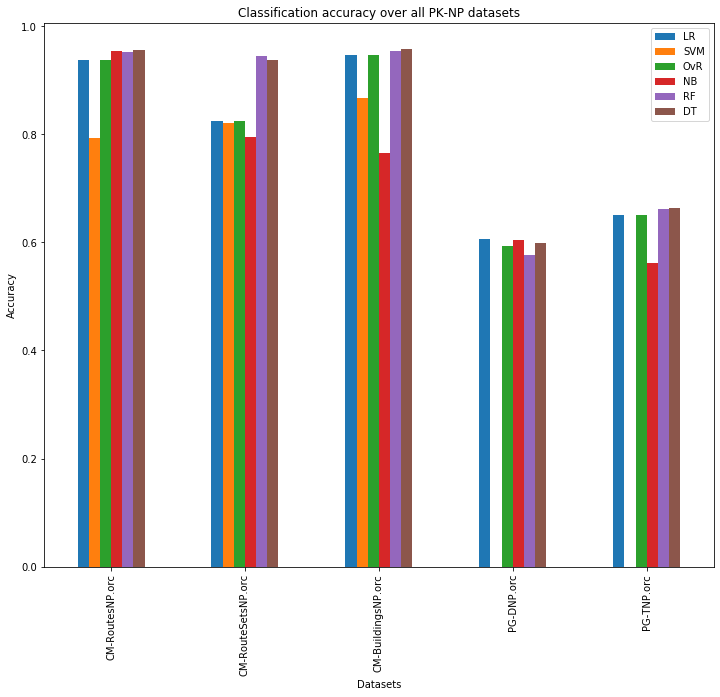

Text(0.5, 1.0, 'Classification accuracy over all PK-NP datasets')

In [0]:
NP = dictsaved[0]
P = dictsaved[1]
datasetDict = {}
for dataset in NP.keys():
  acc = NP[dataset]["Accuracy"]
  datasetDict[dataset] = acc
import pandas as pd
from matplotlib import pyplot as plt
dftest = pd.DataFrame(datasetDict).transpose()
dftest.plot(kind="bar",figsize = (12,10))
plt.xlabel("Datasets")
plt.ylabel("Accuracy")
plt.title("Classification accuracy over all PK-NP datasets")

we then defined a few functions key to run assessment 2 (finding the best performing classifiers' results)

In [0]:
def findBestClassifier(res):
  acc = res['Accuracy']
  classifier = max(acc, key=acc.get)
  return (classifier,acc[classifier])

In [0]:
def P_NP_Comparison(resNP,resP,datasets,datasetsP):
  
  NP_dict = {}
  P_dict = {}
  for dataset in datasets:
    NP_dict[dataset]=findBestClassifier(resNP[dataset])[1]
  for datasetP in datasetsP:
    P_dict[datasetP]=findBestClassifier(resP[datasetP])[1]
  return {"PK-NP":NP_dict,"PK-P":P_dict}

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-234> in <module> 
 9 return { "PK-NP" : NP_dict , "PK-P" : P_dict } 
 10 
 ---> 11 plotRes ( P_NP_Comparison ( dictsaved [ 0 ] , dictsaved [ 1 ] , datasets , datasetsP ) , "Primitive Type influnence" , True ) 

 NameError : name 'plotRes' is not defined

In [0]:
P_NP_Comparison(dictsaved[0],dictsaved[1],datasets,datasetsP)["PK-P"].items()
def organized(dict1,dict2):
  fullOrganizedDict={}
  list1 = list(dict1)
  list2 = list(dict2)
  for i in range(len(list1)):
    
    fullOrganizedDict[list1[i]]= dict1[list1[i]]
    fullOrganizedDict[list2[i]] = dict2[list2[i]]
  return fullOrganizedDict
organized_data = organized(P_NP_Comparison(dictsaved[0],dictsaved[1],datasets,datasetsP)["PK-NP"],P_NP_Comparison(dictsaved[0],dictsaved[1],datasets,datasetsP)["PK-P"])

In [0]:
organized_data

Out[10]: {'CM-BuildingsNP.orc': 0.9583074051026758,
 'CM-BuildingsP.orc': 0.9631480324797002,
 'CM-RoutesNP.orc': 0.9559386973180076,
 'CM-RoutesP.orc': 0.964769647696477,
 'CM-RouteSetsNP.orc': 0.9446366782006921,
 'CM-RouteSetsP.orc': 0.9606625258799172,
 'PG-TNP.orc': 0.6639118457300276,
 'PG-TP.orc': 0.8450704225352113,
 'PG-DNP.orc': 0.6071428571428571,
 'PG-DP.orc': 0.6807387862796834}

we then plot out the final results here

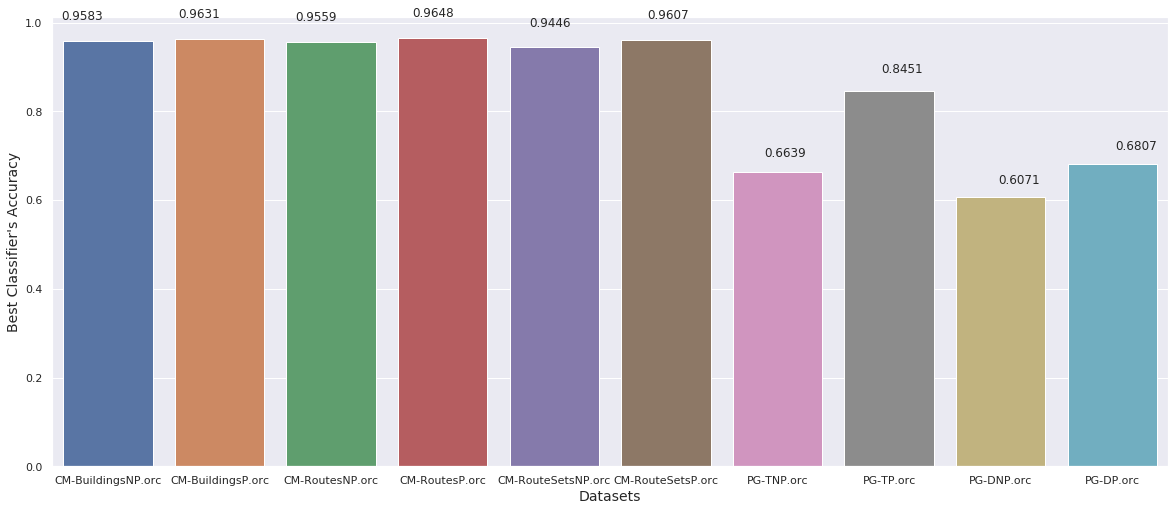

In [0]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
def splot(dictsaved,datasets,datasetsP):
  sns.set(rc={'figure.figsize':(20,8.27)})
  
  df=pd.DataFrame(organized(P_NP_Comparison(dictsaved[0],dictsaved[1],datasets,datasetsP)["PK-NP"],P_NP_Comparison(dictsaved[0],dictsaved[1],datasets,datasetsP)["PK-P"]).items())
  

  splot=sns.barplot(x=0,y=1,data = df.iloc[0:10])
  for p in splot.patches:
      splot.annotate(str(p.get_height().round(4)), ((p.get_x() * 1.05), (p.get_height() * 1.05)))
  
  xlabelstr = "Datasets"


  plt.xlabel(xlabelstr, size =14)
  plt.ylabel("Best Classifier's Accuracy", size = 14)
splot(dictsaved,datasets,datasetsP)

we can also find the dictionaries that contain the best classifiers results as well

In [0]:

def bestClassifierDict(dictsaved,datasets,datasetsP,primitive):
  bestCdict = {}
  if primitive:
    dtsd = dictsaved[1]
    datasrc = datasetsP
  else:
    dtsd = dictsaved[0]
    datasrc = datasets
  for data in datasrc:
    bestCdict[data]=(findBestClassifier(dtsd[data]))
  return bestCdict

#return best in PK-P
pd.DataFrame(bestClassifierDict(dictsaved,datasets,datasetsP,True).items())

Out[14]:

,0,1
0,CM-BuildingsP.orc,"(DT, 0.9631480324797002)"
1,CM-RoutesP.orc,"(RF, 0.964769647696477)"
2,CM-RouteSetsP.orc,"(RF, 0.9606625258799172)"
3,PG-TP.orc,"(RF, 0.8450704225352113)"
4,PG-DP.orc,"(OvR, 0.6807387862796834)"


In [0]:
#return the best in PK-NP
pd.DataFrame(bestClassifierDict(dictsaved,datasets,datasetsP,False).items())

Out[15]:

,0,1
0,CM-BuildingsNP.orc,"(DT, 0.9583074051026758)"
1,CM-RoutesNP.orc,"(DT, 0.9559386973180076)"
2,CM-RouteSetsNP.orc,"(RF, 0.9446366782006921)"
3,PG-TNP.orc,"(DT, 0.6639118457300276)"
4,PG-DNP.orc,"(LR, 0.6071428571428571)"
